### Import project libraries ###

In [ ]:
!pip install --upgrade git+https://github.com/huggingface/diffusers.git transformers accelerate scipy

In [1]:
import requests
import json
from PIL import Image, ImageDraw, ImageFont
import PIL
import datetime
import os
from IPython.display import clear_output
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

### Download Stable Diffusion 2 model from Hugging Face ###
This will take a few minutes the first time you run it. Read More at https://huggingface.co/stabilityai/stable-diffusion-2

In [ ]:
model_id = "stabilityai/stable-diffusion-2"

scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

### Function to fetch forecasts from weatherapi.com ###
Sign up for an api key here https://www.weatherapi.com/

In [3]:
def get_forecast(city):
    url = 'http://api.weatherapi.com/v1/forecast.json?key=' + str(os.environ.get('WEATHER_API_KEY')) + '&q=' + city + '&days=7'
    response = requests.get(url)
    json_response = json.loads(response.text)
    forecasts = json_response['forecast']['forecastday']
    return forecasts

### Function that produces generated images for each forecast ###

In [4]:
def generate_forecast(forecasts,city):
    
    #each city will have multiple forecasts for each day of the week. 
    for forecast in forecasts:
        
        #Set file name for generated image
        file_name = "images/" + str(city['city']) + "-" + str(forecast['date']) + ".png"
    
        #If snow is expected, make sure we include it in the prompt
        if forecast['day']['totalsnow_cm'] > 0:
            snow_text = " " + str(forecast['day']['totalsnow_cm']) + "cm expected snow "
        else:
            snow_text = ""
    
        #Generate the prompt given the city and forecast details
        prompt = f"digital photo, realistic colors, Insane level of details, high contrast, hyper realistic, cinematic, composition, { str(city['city']) } near the { str(city['picture']) }, shot at 12pm weather condition:{ str(forecast['day']['condition']['text']) }{ snow_text } date:{ str(forecast['date']) } temp:{ str(forecast['day']['avgtemp_f']) } degrees F "
        
        ## Output forecast info
        print('city:', city['city'])
        print('date:', forecast['date'])
        print('forecast:', forecast['day']['condition']['text'])
        print('temp:',str(forecast['day']['avgtemp_f']))        
        print(prompt)
        
        #Generate the image
        image = pipe(prompt, height=768, width=768).images[0]

        #save the generated image without text overlay - Will be overwritten below
        image.save(file_name)
        
        #clear cell output for each new forecast
        clear_output(wait=True)

        #Create the text overlay for the image and resave. 
        pillow_img = Image.open(file_name)
        draw = ImageDraw.Draw(pillow_img)
        font = ImageFont.truetype("FreeMono.ttf", size=50)
        font_small = ImageFont.truetype("FreeMono.ttf", size=35)
        temp_display_text = "low " + str(forecast['day']['mintemp_f']) + " high " + str(forecast['day']['maxtemp_f'])
        day_of_week_text = datetime.datetime.strptime(forecast['date'], '%Y-%m-%d').strftime('%A')
        draw.text((10, 550),day_of_week_text,(255,255,255), font=font)
        draw.text((10, 650),city['city'],(255,255,255), font=font)
        draw.text((10, 695),forecast['day']['condition']['text'],(255,255,255), font=font_small)
        draw.text((10, 725),temp_display_text,(255,255,255), font=font_small)
        pillow_img.save(file_name)
        pillow_img.show()
            

In [5]:
def main():
    #List of cities to generate and decription of image to generate.
    cities = [
              {'city':'Bend, Oregon','picture' : 'Mountains and a Lake'},
              {'city':'Government camp, Oregon','picture' : 'Mount Hood'},
              {'city':'Coos Bay, Oregon','picture' : 'the bay in the center, the bay water'},
              {'city':'Ashland, Oregon','picture' : 'Mountains and Lakes'},
              {'city':'Portland, Oregon','picture' : 'downtown overlooking the city'},
              {'city':'Cannon Beach, Oregon','picture' : 'the beach near Haystack Rock'}
             ]
    
    json_output = {}

    for city in cities:
        print (city['city'])
        forecasts = get_forecast(city['city'])
        generate_forecast(forecasts,city)
        #add forecast to output
        json_output[city['city']] = forecasts

    #format output to be saved in a file
    json_object = json.dumps(json_output, indent=4)

    #write the forecasts to a json file
    with open("output.json", "w") as outfile:
        outfile.write(json_object)
    

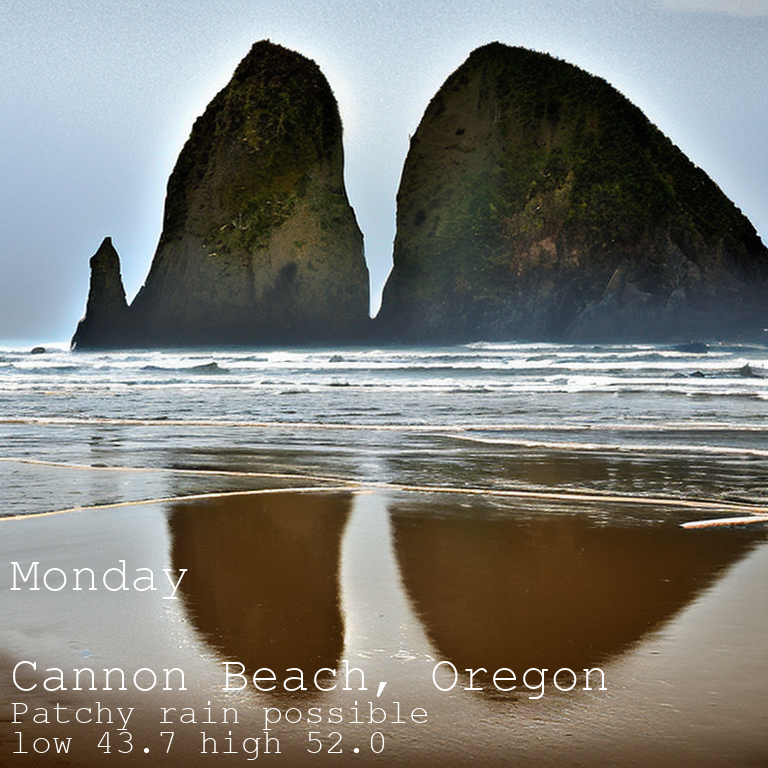

In [6]:
if __name__ == "__main__":
    main()